# STAGE 0 : PREPARATION

PROBLEM STATEMENT : **Jumlah nasabah bank yang telah mendaftar deposito berjangka pada Perusahaan Bank ABC masih rendah jika dibandingkan dengan total nasabah bank tersebut. Dari total 45.211 nasabah yang ada, hanya sekitar 11,7 % nasabah saja yang mendaftar deposito berjangka.**

GOAL : **Meningkatkan jumlah nasabah bank yang mendaftar deposito berjangka hingga sebesar 20% atau dapat dikatakan  1 dari 5 nasabah bank mendaftar deposito berjangka**

OBJECTIVE : **Melakukan klasifikasi pada customer bank tersebut, sehingga nasabah yang sekiranya tertarik untuk membuka deposito berjangka dapat diprioritaskan terlebih dahulu untuk dihubungi/ditawari deposito berjangka.**

BUSINESS METRICS : **Jumlah nasabah baru yang mendaftar deposito berjangka**

# STAGE 1 : EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'

In [ ]:
df = pd.read_csv('train.csv',sep=';')

## EDA Insight:

### Descriptive Statistics

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Kita dapat melihat bahwa:
* Dataframe memiliki total 45211 baris dan 17 kolom
* Setiap kolom sudah memiliki tipe data yang sesuai
* Dataframe sudah tidak memiliki null value pada setiap kolomnya
* Target klasifikasi adalah kolom `y` dengan tipe data `object`
* Sisanya adalah *feature* (predictor)

In [ ]:
nums = ['age','balance','day','duration','campaign','pdays','previous']
cats = ['job','marital','education','default','housing','loan','contact','month','poutcome','y']

### Memeriksa apakah terdapat data duplikat

In [ ]:
df.duplicated().any()

False

### **Sampling data using `df.sample()`**

In [ ]:
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
27022,36,admin.,divorced,tertiary,no,289,yes,yes,cellular,21,nov,73,4,-1,0,unknown,no
19831,39,management,married,tertiary,no,3590,no,no,cellular,8,aug,198,2,-1,0,unknown,no
12639,29,admin.,single,secondary,no,2802,no,yes,unknown,4,jul,840,2,-1,0,unknown,no
18698,39,technician,single,secondary,no,2,yes,yes,telephone,31,jul,14,29,-1,0,unknown,no
30745,33,technician,single,secondary,no,211,yes,yes,cellular,6,feb,217,2,-1,0,unknown,no


### **Statistical Summary using `df.describe()`**

In [ ]:
df[nums].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Beberapa pengamatan dari *statistical summary* kolom numerik di atas:
* Jika hanya melihat dari kedekatan nilai mean dan median serta posisi Q2 maka distribusi nilai di kolom `age`,`day`,`campaign` terlihat normal/simetrik (*mean* dan *median* cukup dekat, serta nilai Q2 kurang lebih berada di tengah2 Q1 - Q3).
* Sedangkan kolom `balance`,`duration`, tampaknya tidak simetrik, karena mean > median.
* Pada kolom `balance` terlihat bahwa nilai minimum memiliki angka negatif, yang dirasa wajar jika rekening customer tersebut merupakan rekening giro yang sedang menggunakan fasilitas kredit dari bank tersebut
* Pada kolom `pdays` nilai min, 25%, 50%, dan 75% berisikan -1, angka tersebut merupakan suatu indikator bahwa 'client was not previously contacted in previous campaign'.

Untuk membuktikan argumentasi mengenai bentuk distribusi setiap kolom berdasarkan *statistical summary* diatas akan dilakukan pengecekkan skewness score untuk kolom-kolom numerik tersebut:

In [ ]:
import scipy.stats
for i in range(len(nums)):
    skewness_score = scipy.stats.skew(df[nums[i]])
    if skewness_score <= 2 and skewness_score>=-2:
        print(f'Skewness score kolom {nums[i]} : {scipy.stats.skew(df[nums[i]])}\n(Maka berdistribusi normal)')
    elif skewness_score >2:
        print(f'Skewness score kolom {nums[i]} : {scipy.stats.skew(df[nums[i]])}\n(Maka skew positif)')
    else:
        print(f'Skewness score kolom {nums[i]} : {scipy.stats.skew(df[nums[i]])}\n(Maka skew negatif)')

Skewness score kolom age : 0.6847952047866451
(Maka berdistribusi normal)
Skewness score kolom balance : 8.360030947252687
(Maka skew positif)
Skewness score kolom day : 0.09307592583897241
(Maka berdistribusi normal)
Skewness score kolom duration : 3.1442137770103913
(Maka skew positif)
Skewness score kolom campaign : 4.898487638410557
(Maka skew positif)
Skewness score kolom pdays : 2.615628689259389
(Maka skew positif)
Skewness score kolom previous : 41.84506608797322
(Maka skew positif)


* Berarti untuk sementara bentuk persebaran data dapat dilihat bahwa ternyata hanya kolom `age` dan `day` yang berdistribusi normal/simetrik selebihnya mengalami positif skewness. Namun untuk lebih pastinya lagi akan dilakukan dengan pengecekkan secara visualisasi bentuk distribusi setiap kolom saat melakukan Univariate Analysis

In [ ]:
df[cats].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


Beberapa pengamatan dari *statistical summary* kolom kategorikal di atas:
* Kolom `job` dan `month`  memiliki jumlah nilai unique yang sangat banyak yaitu mencapai 12 nilai unique. Ada kemungkinan feature ini tidak akan terlalu berguna sebagai predictor.
* Mayoritas data customer memilih "no" untuk membuka deposito (dengan frekuensi 39922 dari 45211 data yang ada). Dimana artinya data customer yang memilih untuk membuka deposito hanya sekitar 11,7% dari total data. Hal ini tentunya menjadi suatu permasalahan dikarenakan dapat membuat model menjadi overfit. Harus dilakukan oversampling.

### Univariate Analysis

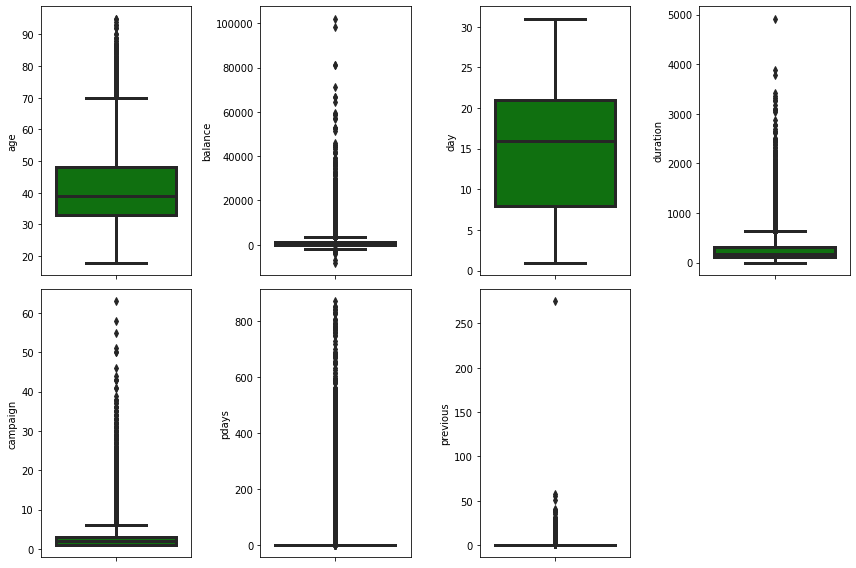

In [ ]:
for i in range(len(nums)):
    plt.subplot(2,4,i+1)
    sns.boxplot(y=df[nums[i]],color='g',orient='v')
    plt.tight_layout()

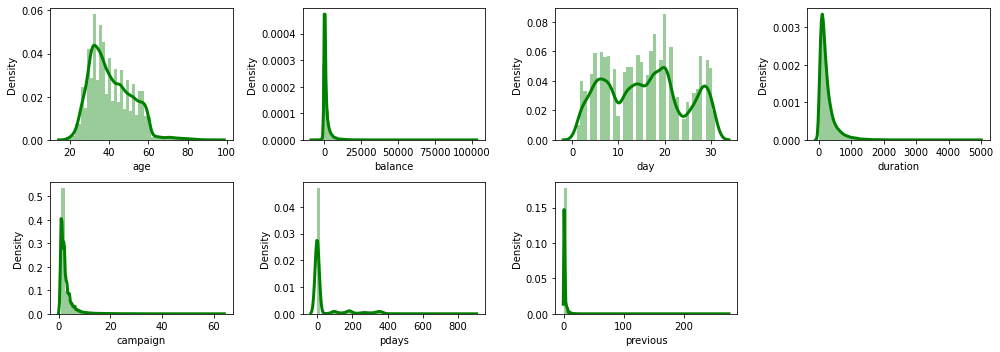

In [ ]:
plt.figure(figsize=(14, 5))
for i in range(len(nums)):
    plt.subplot(2,4,i+1)
    sns.distplot(df[nums[i]],color='g')
    plt.tight_layout()

    Mengenai bentuk distribusi dapat dipastikan bahwa:
* Untuk kolom `balance`, `duration`, `campaign`, `pdays` dan `previous` memiliki distribusi yang terlihat *skewed positif*
* Kolom `day` memiliki distribusi *multimodal*
* Kolom `age` memiliki distribusi yang hampir mendekati normal/simetrik


    Selain itu dapat dilihat juga bahwa:
* Distribusi kolom `age` terkonsentrasi pada umur dibawah 40 tahun
* Dari boxplot dapat dilihat bahwa outlier terlihat utamanya pada kolom `age`, `balance`, `duration`, `campaign`, `pdays` dan `previous`, Pada tahap preprocessing nanti akan dilakukan pengambilan keputusan dalam menghadapi outlier-outlier tersebut. 
* Untuk features yg sebagian besar datanya merupakan outlier jika seandainya pada tahap preprocessing diputuskan untuk melakukan pembersihan terhadap outlier tersebut,sebaiknya dilakukan dengan menetapkan sebuah treshold. Misalkan dengan menetapkan treshold yaitu percentile 95% atau 99%. Sehingga dengan demikian data yang terbuang akibat preprocessing outlier tidak terlalu banyak.

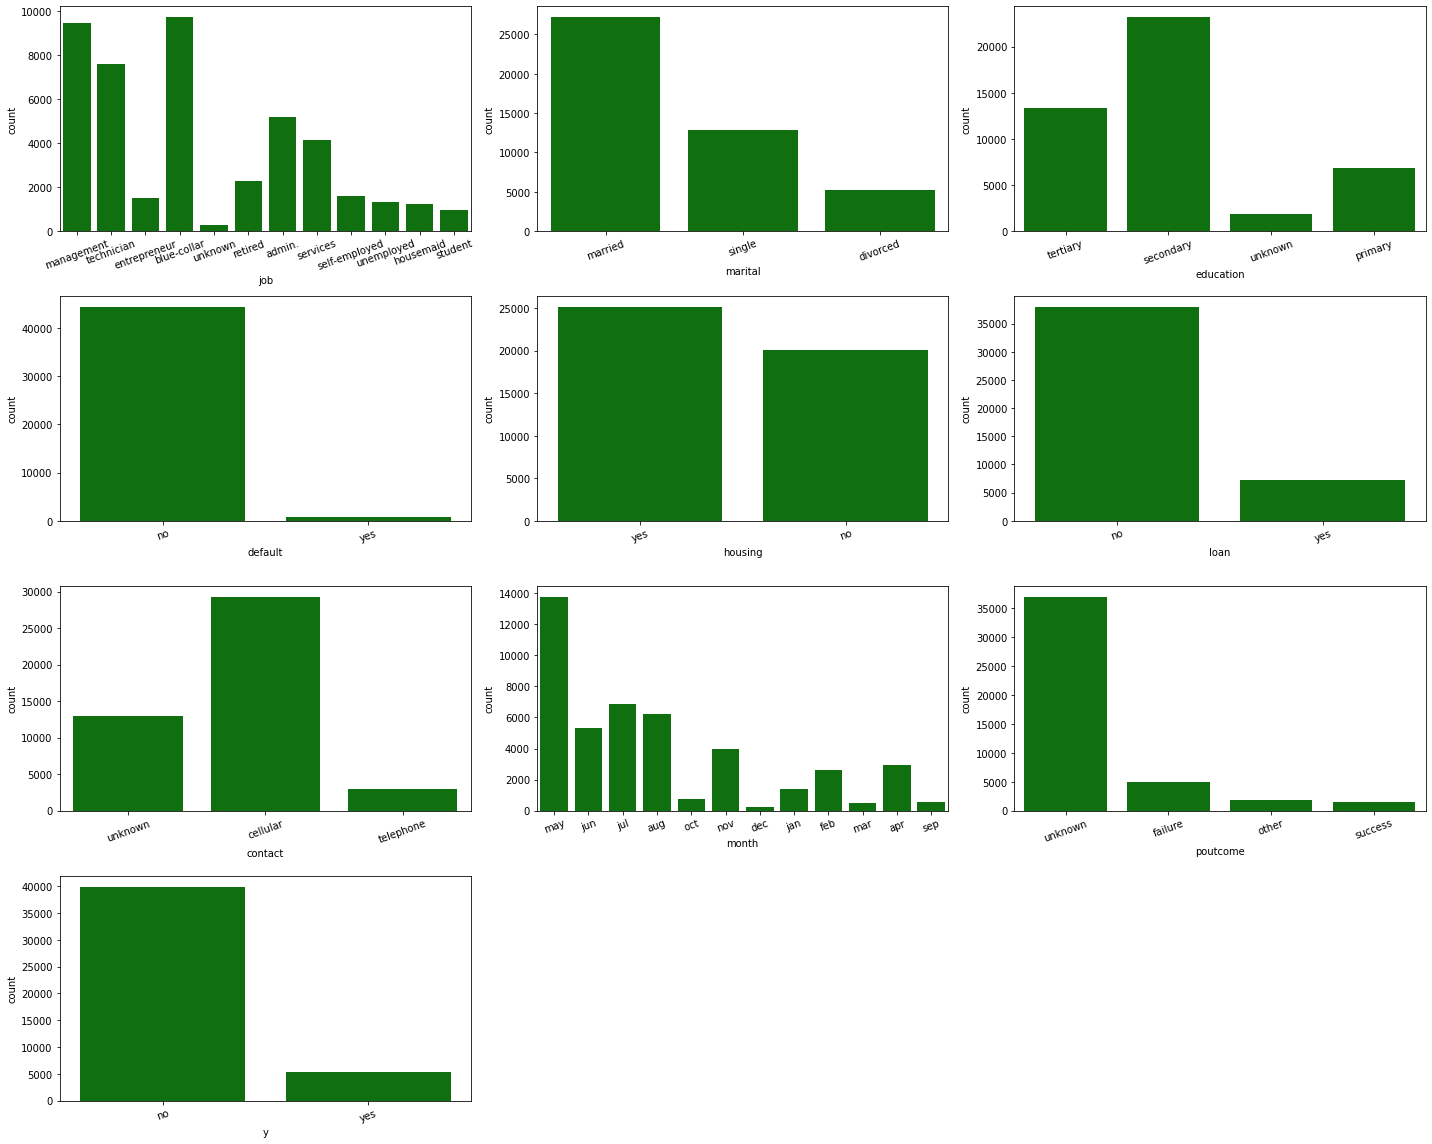

In [ ]:
plt.figure(figsize=(20, 16))
for i in range(len(cats)):
    plt.subplot(4, 3, i+1)
    sns.countplot(df[cats[i]], color='g', orient='v')
    plt.xticks(rotation=20)
    plt.tight_layout()

* Untuk feature `job` meskipun memiliki nilai unique yang banyak dapat dilihat bahwa didominasi hanya oleh 5 jenis pekerjaan yaitu "blue-collar", "management", "technician", "admin", dan "services". Pada saat tahap preprocessing selain dari 5 jenis pekerjaan tersebut dapat dijadikan satu kelompok menjadi jenis "others".
* Seperti pengamatan kita sebelumnya, distribusi kolom target yaitu kolom `y` memiliki 2 value yaitu "yes" dan "no". Namun frekuensi antara value "yes" dan "no" tidak seimbang, dimana value "yes" hanya berkisar 11,7% dari keseluruhan value. Oleh sebab itu nanti harus dilakukan **Oversampling**.
* Untuk kolom `education`,`contact` yang memiliki nilai unknown, jika dirasa perlu pada saat preprocessing bisa digantikan dengan nilai mode nya
* Saat proses preprocessing kolom2 kategorikal ini akan dilakukan encoding.

### Multivariate Analysis

In [ ]:
df_month_vis = df.copy()
df_month_vis = pd.pivot_table(df_month_vis,
                              index=['month'],
                              columns=['y'],
                              aggfunc={'y':'count'})
df_month_vis.columns =['no','yes']
df_month_vis.drop(['no'],axis=1,inplace=True)
df_month_vis.reset_index(inplace=True)
df_month_vis['total_yes'] = df_month_vis['yes'].sum()
df_month_vis['ratio yes (%)'] = round((df_month_vis['yes']/(df_month_vis['total_yes'])) , 2)

In [ ]:
df_month_vis

,month,yes,total_yes,ratio yes (%)
0,apr,577,5289,0.11
1,aug,688,5289,0.13
2,dec,100,5289,0.02
3,feb,441,5289,0.08
4,jan,142,5289,0.03
5,jul,627,5289,0.12
6,jun,546,5289,0.10
7,mar,248,5289,0.05
8,may,925,5289,0.17
9,nov,403,5289,0.08


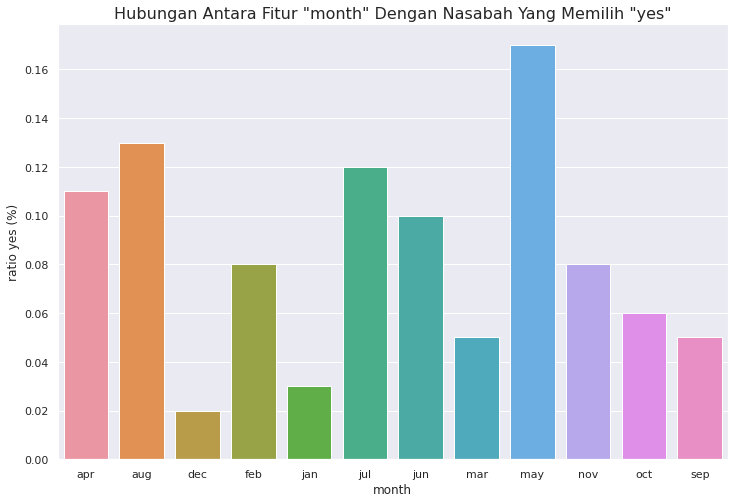

In [ ]:
sns.set_theme(style='darkgrid')
sns.barplot(data=df_month_vis , x='month', y='ratio yes (%)')
plt.title('Hubungan Antara Fitur "month" Dengan Nasabah Yang Memilih "yes"',fontsize=16)
plt.show()

* Dapat dilihat bahwa pada bulan may persentase customer yang melakukan pendaftaran deposito sedikit lebih tinggi dibandingkan bulan-bulan lainnya. Namun jika kita melihat secara keseluruhan pada setiap bulannya jumlah customer yang mendaftar tidaklah berbeda jauh antara satu bulan ke bulan lainnya, bahkan semua bulan tidak ada yg memiliki persentase "yes" lebih besar dari 0,2%. **Hal ini dapat menjadi landasan jika kita memutuskan untuk tidak menggunakan feature `month` terhadap model yang akan kita dibuat, dikarenakan feature `month` tidak memiliki pengaruh yang signifikan perihal seorang customer tertarik mendaftar deposito berjangka**.

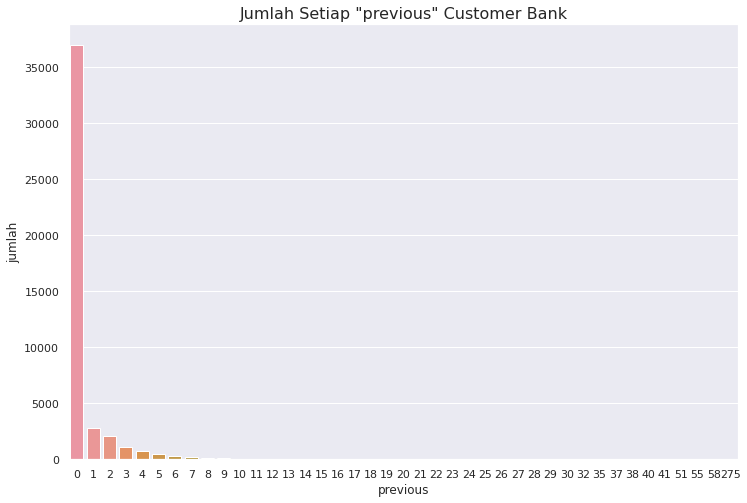

In [ ]:
sns.set_theme(style='darkgrid')
previous_chart = df.groupby('previous').agg({'y':'count'}).reset_index()
previous_chart.columns = ['previous','jumlah']
sns.barplot(data=previous_chart , x='previous', y='jumlah')
plt.title('Jumlah Setiap "previous" Customer Bank',fontsize=16)
plt.show()

* Dapat dilihat bahwa sebanyak lebih dari 35000 nasabah (tepatnya 36954) memiliki previous 0, dimana hal tersebut berarti nasabah belum pernah dihubungi pada campaign sebelumnya. Artinya sekitar 81% nasabah belum pernah dihubungi pada campaign sebelumnya. Dengan hal ini menunjukkan bahwa fitur `previous` tidak berpengaruh terhadap outcome y dikarenakan mayoritas dari customer memang belum pernah dihubungi pada campaign sebelumnya. **Oleh sebab itu hal ini dapat dijadikan sebagai landasan kita apabila ingin memutuskan untuk tidak menggunakan feature `previous` terhadap model yang akan kita dibuat**.

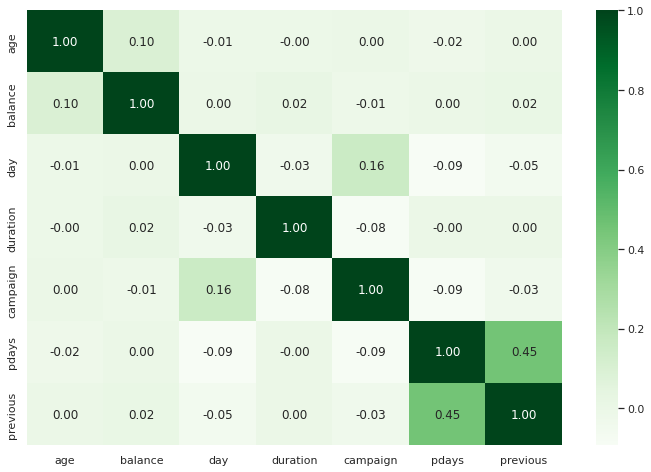

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='Greens', annot=True, fmt='.2f')
plt.show()

* Tidak ada features numerical yang berkorelasi kuat dan dapat dilihat juga bahwa pada features numerical tidak ada yang redundan
* Nantinya setelah melakukan encoding pada tahap preprocessing akan juga dilakukan multivariate analysis untuk mengetahui korelasi antara semua features (baik yang kategorikal maupun numerik) terhadap kolom target yaitu kolom `y`

## Business Insight:

In [ ]:
df_edu_insight = df.copy()
df_edu_insight = pd.pivot_table(df_edu_insight,
                                index=['education'],
                                columns=['y'],
                                aggfunc={'y':'count'})
df_edu_insight.columns =['no','yes']
df_edu_insight.drop(['no'],axis=1,inplace=True)
df_edu_insight.reset_index(inplace=True)
df_edu_insight['total_yes'] = df_edu_insight['yes'].sum()
df_edu_insight['ratio yes (%)'] = round((df_edu_insight['yes']/(df_edu_insight['total_yes'])) , 2)

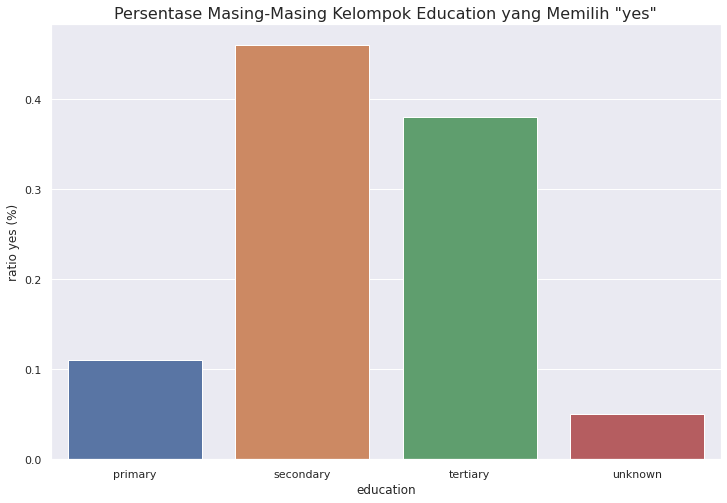

In [ ]:
sns.set_theme(style='darkgrid')
sns.barplot(data=df_edu_insight , x='education', y='ratio yes (%)')
plt.title('Persentase Masing-Masing Kelompok Education yang Memilih "yes"',fontsize=16)
plt.show()

* Dapat dilihat bahwa tingkat edukasi ternyata juga berpengaruh dalam keputusan seorang customer memilih untuk mendaftar deposito berjangka. Dari visualisasi diatas dapat dilihat bahwa kelompok education secondary dan tertiary merupakan kelompok education yang paling banyak memilih untuk mendaftar deposito berjangka, namun terlihat sangat jauh perbedaannya dengan kelompok education primary. Kiranya pihak bank bisa mulai melakukan kerjasama dengan sektor pendidikan untuk melakukan edukasi kepada anak-anak muda dengan cara memberikan seminar-seminar mengenai pentingnya berinvestasi (dalam konteks ini contohnya adalah deposito). Dengan demikian kesadaran dan keinginan untuk berinvestasi pun akan mulai tumbuh kepada generasi muda sehingga secara tidak langsung akan berpeluang meningkatkan jumlah orang yang akan membuka deposito dari segala tingkat pendidikan.

In [ ]:
df_contact_insight = df.copy()
df_contact_insight = pd.pivot_table(df_contact_insight,
                                index=['contact'],
                                columns=['y'],
                                aggfunc={'y':'count'})
df_contact_insight.columns =['no','yes']
df_contact_insight.drop(['no'],axis=1,inplace=True)
df_contact_insight.reset_index(inplace=True)
df_contact_insight['total_yes'] = df_contact_insight['yes'].sum()
df_contact_insight['ratio yes (%)'] = round((df_contact_insight['yes']/(df_contact_insight['total_yes'])) , 2)

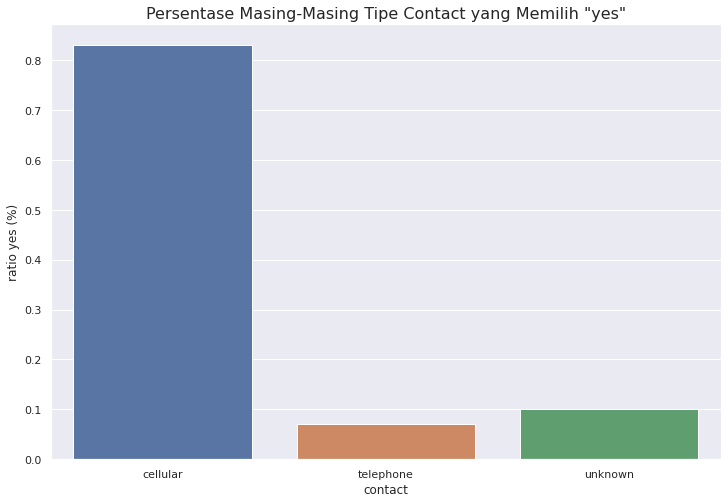

In [ ]:
sns.set_theme(style='darkgrid')
sns.barplot(data=df_contact_insight , x='contact', y='ratio yes (%)')
plt.title('Persentase Masing-Masing Tipe Contact yang Memilih "yes"',fontsize=16)
plt.show()

* Bisa dilihat melalui visualisasi diatas bahwa tipe contact cellular merupakan tipe contact yang paling banyak menghasilkan customer untuk mendaftar deposito berjangka. Hal ini bisa terjadi karena di era sekarang ini orang-orang lebih banyak melakukan komunikasi melalui telepon celullar dibandingkan telepon biasa, dan hampir setiap orang pasti mempunyai telepon cellular. Dari sini pihak bank dapat mulai merubah strategi campaign untuk memprioritaskan melakukan contact melalui telepon celullar. Selain itu pihak bank sebelum melakukan panggilan secara langsung ke nomor telepon celullar, bisa juga bisa melakukan campaign melalui email atau melalui whatsapp sebagai tahapan awal dalam menawarkan deposito berjangka. Dengan demikian peluang customer yang mendaftar deposito berjangka akan meningkat.

In [ ]:
df_marital_insight = df.copy()
df_marital_insight = pd.pivot_table(df_marital_insight,
                                index=['marital'],
                                columns=['y'],
                                aggfunc={'y':'count'})
df_marital_insight.columns =['no','yes']
df_marital_insight.drop(['no'],axis=1,inplace=True)
df_marital_insight.reset_index(inplace=True)
df_marital_insight['total_yes'] = df_marital_insight['yes'].sum()
df_marital_insight['ratio yes (%)'] = round((df_marital_insight['yes']/(df_marital_insight['total_yes'])) , 2)

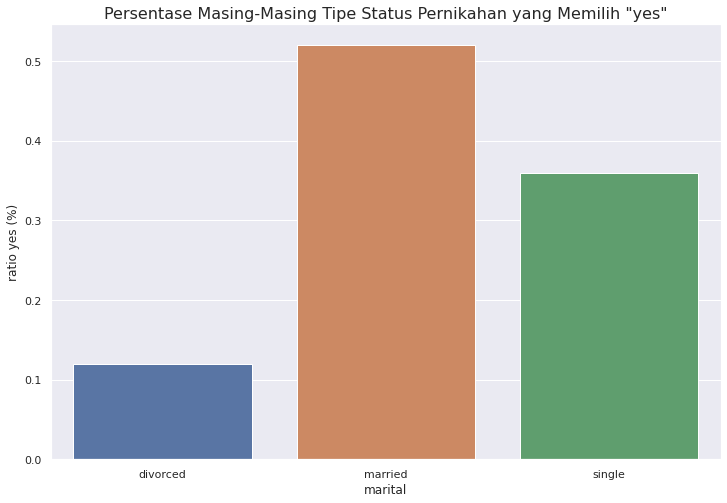

In [ ]:
sns.set_theme(style='darkgrid')
sns.barplot(data=df_marital_insight , x='marital', y='ratio yes (%)')
plt.title('Persentase Masing-Masing Tipe Status Pernikahan yang Memilih "yes"',fontsize=16)
plt.show()

* Hasil visualisasi diatas dapat dilihat bahwa customer yang berstatus menikah dan single yang memiliki persentase paling besar untuk mendaftar deposito berjangka. Oleh sebab itu pihak bank bisa mulai fokus untuk memprioritaskan customer yang berstatus menikah dan single. Selain itu untuk meningkatkan kedua kelompok tersebut dalam mendaftar deposito berjangka pihak bank saat melakukan campaign kepada masing-masing individu dua kelompok tersebut dapat melakukan promosi dengan strategi pendekatan yang berbeda. Misalkan kepada kelompok "single" bisa melakukan promosi seperti "dengan bunga deposito dalam setahun adalah x% maka kira-kira dalam y tahun dana menikah akan dapat terkumpul". Sedangkan untuk kelompok "married" bisa melakukan promosi seperti "dengan bunga deposito dalam setahun adalah x% maka dana pendidikan untuk anak/dana pensiun saat masa tua akan terjamin"

# STAGE 2 : DATA PREPROCESSING

* month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec") <br>
* day: last contact day of the month (numeric) <br>
* previous: number of contacts performed before this campaign and for this client (numeric) <br>
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

Seperti yang disampaikan pada saat EDA ada beberapa features yang diputuskan untuk tidak digunakan seperti `month`, `previous`. Selain itu ada feature lain yang diputuskan untuk digunakan yaitu `day`,dan `pdays` dikarenakan kedua fitur tersebut secara tidak langsung berhubungan dengan feature yang ingin dibuang yaitu `month` dan `previous`

In [ ]:
df = df.drop(['month','previous','day','pdays'],axis=1)

**HANDLING OUTLIER** <br>
Untuk sementara diputuskan untuk tidak menghapus semua data outlier, dikarenakan data outlier tersebut dirasa memiliki nilai yang penting dalam pemodelan machine learning yang akan dilakukan. Jika nantinya performa machine learning dari berbagai algoritma yang dibuat masih belum memuaskan maka akan dicoba untuk menghapus outlier-outlier tersebut.

**HANDLING `job` UNIQUE VALUES**

In [ ]:
df.loc[((df['job']=='enterpreneur') | (df['job'] == 'unknown') |
        (df['job']=='retired') | (df['job']=='self-employed') | (df['job']=='unemployed') |
        (df['job']=='housemaid') | (df['job']=='student')) ,'job'] = 'others'

**ENCODING**

Label Encoding = default, housing, loan, y, education, contact <br>
One Hot Encoding = job, marital, poutcome

In [ ]:
#Label Encoding:

#default
df['default'] = df['default'].apply(lambda x : 0 if x =='no' else 1 )

#housing
df['housing'] = df['housing'].apply(lambda x : 0 if x =='no' else 1 )

#loan
df['loan'] = df['loan'].apply(lambda x : 0 if x =='no' else 1 )

#y
df['y'] = df['y'].apply(lambda x : 0 if x =='no' else 1 )

#education
df['education'] = df['education'].apply(lambda x : 0 if x =='primary' else 1 if x=='secondary' else 2 )

#contact
df['contact'] = df['contact'].apply(lambda x: 0 if x=='cellular' else 1)

In [ ]:
#One Hot Encoding:
ohe_job = pd.get_dummies(df['job'], prefix='job')
ohe_marital = pd.get_dummies(df['marital'], prefix='marital')
ohe_poutcome = pd.get_dummies(df['poutcome'], prefix='poutcome')

In [ ]:
df = pd.concat([df,ohe_job,ohe_marital,ohe_poutcome],axis=1)
df.drop(['job','marital','poutcome'],axis=1,inplace=True)

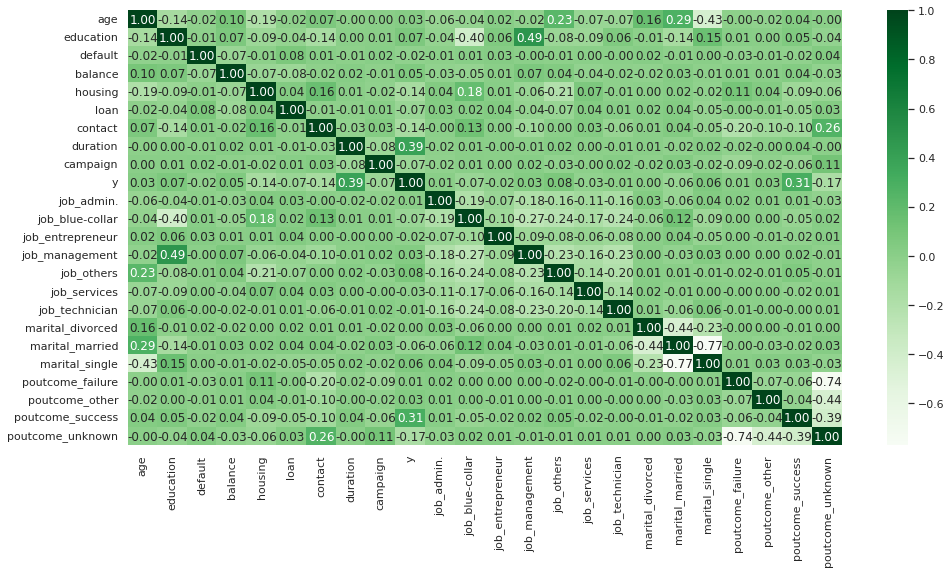

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), cmap='Greens', annot=True, fmt='.2f')
plt.show()

In [ ]:
correlations = df.corr()['y'].sort_values()
correlations

poutcome_unknown   -0.167051
housing            -0.139173
contact            -0.135873
campaign           -0.073172
job_blue-collar    -0.072083
loan               -0.068185
marital_married    -0.060260
job_services       -0.027864
default            -0.022419
job_entrepreneur   -0.019662
job_technician     -0.008970
marital_divorced    0.002772
job_admin.          0.005637
poutcome_failure    0.009885
age                 0.025155
poutcome_other      0.031955
job_management      0.032919
balance             0.052838
marital_single      0.063526
education           0.070058
job_others          0.078441
poutcome_success    0.306788
duration            0.394521
y                   1.000000
Name: y, dtype: float64

Dapat dilihat bahwa tidak ada feature yang berkorelasi kuat dengan Target. Namun terdapat fitur yang redundan yaitu `marital_married` dan `marital_single` serta `poutcome_failure` dan `poutcome_unknown`. Untuk fitur2 yang redundan ini akan digunakan hanya salah satunya.

In [ ]:
df.drop(['marital_single','poutcome_unknown'],axis=1,inplace=True)

**SPLITTING TRAIN AND TEST DATA**

In [ ]:
X = df.drop(['y'],axis=1)
y = df['y']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)
print(f'Jumlah Data Train : {X_train.shape[0]}')
print(f'Jumlah Data Test: {X_test.shape[0]}')

Jumlah Data Train : 36168
Jumlah Data Test: 9043


**RESCALING FEATURES**

In [ ]:
#Rescaling train data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
msc = MinMaxScaler()
ssc = StandardScaler()
# df[['age','balance','duration']] = msc.fit_transform(df[['age','balance','duration']])
X_train[['age','balance','duration']] = ssc.fit_transform(X_train[['age','balance','duration']])

In [ ]:
#Rescaling test data
X_test[['age','balance','duration']] = ssc.transform(X_test[['age','balance','duration']])

In [ ]:
# BEFORE OVERSAMPLING
print(pd.Series(y_train).value_counts())

0    31970
1     4198
Name: y, dtype: int64


**OVERSAMPLING using SMOTE**

Seperti yang dilihat pada saat EDA, kolom TARGET memiliki proporsi yang tidak seimbang. Dimana value 1 ('yes') hanya sekitar 11,7% dari total data. Oleh sebab itu akan dilakukan oversampling terlebih dahulu.

In [ ]:
# OVERSAMPLING
from imblearn import over_sampling
X_oversampling , y_oversampling = over_sampling.SMOTE(random_state=42).fit_resample(X_train,y_train)
print(pd.Series(y_oversampling).value_counts())

0    31970
1    31970
Name: y, dtype: int64


Perlu dicoba juga untuk melakukan undersampling

In [ ]:
# UNDERSAMPLING
# from imblearn import under_sampling
# X_undersampling , y_undersampling = under_sampling.RandomUnderSampler(random_state=42).fit_resample(X_train,y_train)
# print(pd.Series(y_undersampling).value_counts())